# 🤖 Intro to Machine Learning Week 1
## Part 2 - Logistic Regression
By Ellie Zhou, July 2025

Now let's try **Logistic Regression** - predicting categories. Specifically, we'll build a spam email detection model.

### The Problem:
We want to classify emails as "spam" or "not spam" based on the following features:
- Number of exclamation marks
- Number of capital letters
- Length of the email
- Time sent (hour of day)

### Step 1: Create Email Dataset

In [2]:
# Import all the libraries we need
import pandas as pd                 # For data manipulation (like Excel on steroids!)
import numpy as np                  # For mathematical operations
import matplotlib.pyplot as plt     # For creating plots and graphs
import seaborn as sns              # For beautiful statistical visualizations

# Machine Learning libraries
from sklearn.model_selection import train_test_split  # For splitting our data
from sklearn.linear_model import LinearRegression     # Linear regression model
from sklearn.linear_model import LogisticRegression   # Logistic regression model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler      # For scaling our data
from sklearn.metrics import confusion_matrix          # For confusion matrix

# Make our plots look nice
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print("Ready to start our machine learning journey!")

All libraries imported successfully!
Ready to start our machine learning journey!


In [8]:
import numpy as np
import pandas as pd

# Make results reproducible
np.random.seed(42)

# Total number of emails in our toy dataset
n_emails = 500

# 1) SPLIT INTO SPAM VS REAL
# We'll choose 40% spam, 60% ham
n_spam = int(0.4 * n_emails)
n_real  = n_emails - n_spam

# 2) Generate "spam" features
# Number of exclamation marks: uniformly between 5 and 15
spam_exclamations = np.random.randint(5, 16, size=n_spam)

# Number of capital letters: uniformly between 30 and 100
spam_caps = np.random.randint(30, 101, size=n_spam)

# Email length (words): normal around 200 ± 50 words
spam_length = np.random.normal(loc=200, scale=50, size=n_spam)

# Hour sent: pick from overnight hours
spam_hour = np.random.choice([0,1,2,3,4,22,23], size=n_spam)

# Target Label = 1 for spam
spam_labels = np.ones(n_spam, dtype=int)

# 3) Generate "real" (not spam) features
# Exclamations: uniformly 0–3
real_exclamations = np.random.randint(0, 4, size=n_real)

# Caps: uniformly 0–30
real_caps = np.random.randint(0, 31, size=n_real)

# Email Length: normal around 400 ± 80 words.
#Sample email lengths from a normal gaussian distribution
real_length = np.random.normal(loc=400, scale=80, size=n_real)

# Hour sent: daytime hours
real_hour = np.random.choice(range(8,20), size=n_real)

# Label = 0 for not spam
real_labels = np.zeros(n_real, dtype=int)

# 4) Combine all features and labels from spam and real into a single dataframe
# Note: Dataframe is a common way to store tabular data
email_data = pd.DataFrame({
    'Exclamations':     np.concatenate([spam_exclamations, real_exclamations]),
    'Capital_Letters':  np.concatenate([spam_caps, real_caps]),
    'Email_Length':     np.concatenate([spam_length, real_length]),
    'Hour_Sent':        np.concatenate([spam_hour, real_hour]),
    'Is_Spam':          np.concatenate([spam_labels, real_labels])
})

# 5) Clean data
# Ensure email length doesn't go unreasonably small
email_data['Email_Length']    = email_data['Email_Length'].clip(lower=20)  # at least 20 words

# 6) Shuffle the rows
# We don't want a chunk of samples that are all spam and then a chunk that are all "real"
# because then our training will be messed up
email_data = email_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 7) Print out our dataset that we just created
print(f" Created email dataset with {len(email_data)} emails")
print(f" Distribution: {int(email_data['Is_Spam'].sum())} spam, {int(len(email_data) - email_data['Is_Spam'].sum())} not spam\n")

print(" ==== First 10 emails ====")
display_df = email_data.head(10).copy()
display_df['Spam_Label'] = display_df['Is_Spam'].map({1: 'Spam', 0: 'Real'})
print(display_df[['Exclamations','Capital_Letters','Email_Length','Hour_Sent','Spam_Label']])

 Created email dataset with 500 emails
 Distribution: 200 spam, 300 not spam

 ==== First 10 emails ====
   Exclamations  Capital_Letters  Email_Length  Hour_Sent Spam_Label
0             2               20    292.698026         12       Real
1            11               49    199.559148          4       Spam
2             1               18    325.038240         16       Real
3            11               54    277.563143          1       Spam
4            11               75    223.681369          3       Spam
5             0                4    416.845438         15       Real
6             0               20    459.366767         19       Real
7            14               52    237.098151          2       Spam
8            14               97    260.246146          0       Spam
9             1               14    360.836845         16       Real


### Step 2: Explore Email Data
Let's visualize the differences between spam and normal emails!

/tmp/ipython-input-10-262935921.py:55: UserWarning: Glyph 128231 (\N{E-MAIL SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


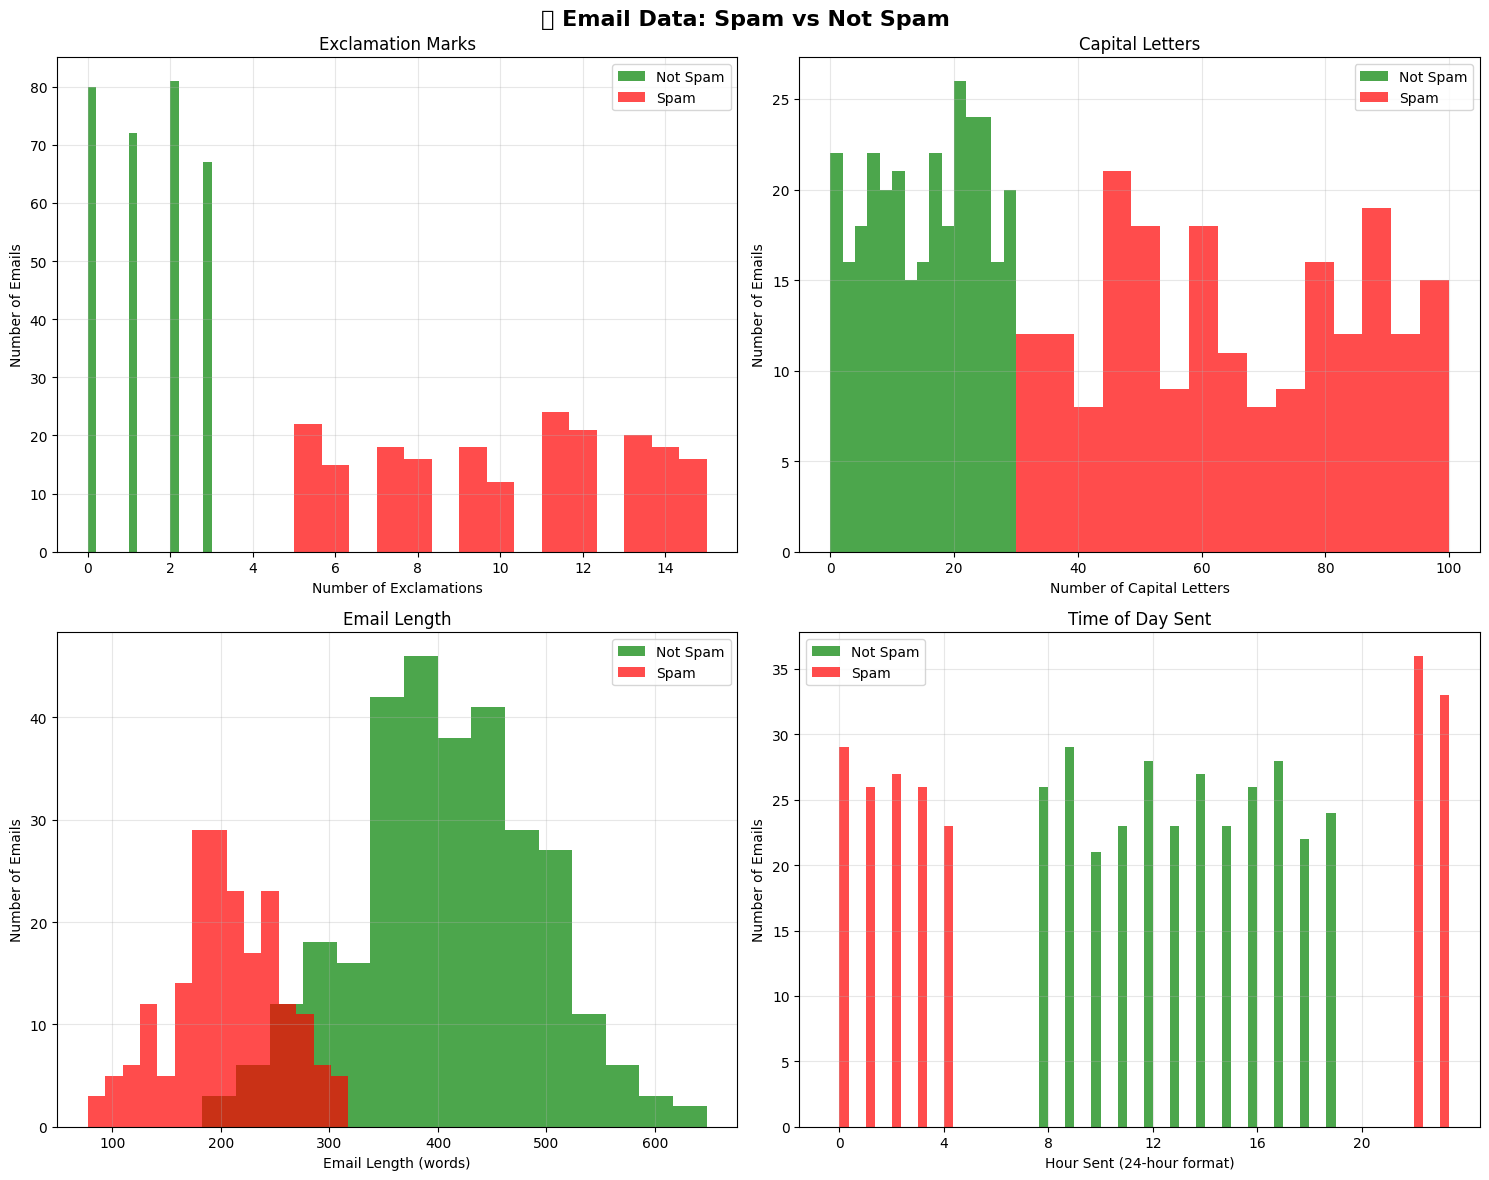

 What patterns do you see?
• Spam emails have MORE exclamation marks
• Spam emails have MORE capital letters
• Spam emails tend to be SHORTER
• Spam emails are often sent at ODD HOURS


In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📧 Email Data: Spam vs Not Spam', fontsize=16, fontweight='bold')

# Separate data
spam_emails = email_data[email_data['Is_Spam'] == 1]
real_emails = email_data[email_data['Is_Spam'] == 0]

# Plot 1: Exclamations
axes[0,0].hist(real_emails['Exclamations'], bins=15, alpha=0.7, label='Not Spam', color='green')
axes[0,0].hist(spam_emails['Exclamations'], bins=15, alpha=0.7, label='Spam', color='red')
axes[0,0].set_xlabel('Number of Exclamations')
axes[0,0].set_ylabel('Number of Emails')
axes[0,0].set_title('Exclamation Marks')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Capital Letters
axes[0,1].hist(real_emails['Capital_Letters'], bins=15, alpha=0.7, label='Not Spam', color='green')
axes[0,1].hist(spam_emails['Capital_Letters'], bins=15, alpha=0.7, label='Spam', color='red')
axes[0,1].set_xlabel('Number of Capital Letters')
axes[0,1].set_ylabel('Number of Emails')
axes[0,1].set_title('Capital Letters')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Email Length
axes[1,0].hist(real_emails['Email_Length'], bins=15, alpha=0.7, label='Not Spam', color='green')
axes[1,0].hist(spam_emails['Email_Length'], bins=15, alpha=0.7, label='Spam', color='red')
axes[1,0].set_xlabel('Email Length (words)')
axes[1,0].set_ylabel('Number of Emails')
axes[1,0].set_title('Email Length')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Hour Sent
spam_hours = spam_emails['Hour_Sent'].value_counts().sort_index()
ham_hours = real_emails['Hour_Sent'].value_counts().sort_index()

hours = range(24)
spam_counts = [spam_hours.get(h, 0) for h in hours]
ham_counts = [ham_hours.get(h, 0) for h in hours]

x = np.arange(24)
width = 0.35
axes[1,1].bar(x - width/2, ham_counts, width, label='Not Spam', color='green', alpha=0.7)
axes[1,1].bar(x + width/2, spam_counts, width, label='Spam', color='red', alpha=0.7)
axes[1,1].set_xlabel('Hour Sent (24-hour format)')
axes[1,1].set_ylabel('Number of Emails')
axes[1,1].set_title('Time of Day Sent')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(range(0, 24, 4))

plt.tight_layout()
plt.show()

print(" What patterns do you see?")
print("• Spam emails have MORE exclamation marks")
print("• Spam emails have MORE capital letters")
print("• Spam emails tend to be SHORTER")
print("• Spam emails are often sent at ODD HOURS")

### Step 3: Build Our Logistic Regression Model

**Key difference from Linear Regression:**
- Linear Regression predicts **numbers** (house prices)
- Logistic Regression predicts **probabilities** (spam probability), which can then be used to predict categories

In [13]:
# Prepare features and labels

#Extract features and labels from our dataframe
X_email = email_data[['Exclamations', 'Capital_Letters', 'Email_Length', 'Hour_Sent']]
y_email = email_data['Is_Spam']

print(" Features (X) - first 5:")
print(X_email.head())
print("\n Labels (y) - first 5:")
print(y_email.head())

# Split the data
# 80% of the data will be for training
# 20% of the data will be for testing
X_train_email, X_test_email, y_train_email, y_test_email = train_test_split(
    X_email, y_email, test_size=0.2, random_state=42, stratify=y_email
)

print(f"\n Data split:")
print(f"• Training: {len(X_train_email)} emails")
print(f"• Testing: {len(X_test_email)} emails")

# Scale features
# Scales all features to have a mean of 0 and standard deviation of 1
# This is generally good practice for any model because it ensures that
# all your features lie on the same scale and makes training more reliable
print("\n Scaling features...")
email_scaler = StandardScaler()
X_train_scaled = email_scaler.fit_transform(X_train_email)
X_test_scaled = email_scaler.transform(X_test_email)

# Create and train model
print("\n Training Logistic Regression...")
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train_email)
print(" Model training complete!")

 Features (X) - first 5:
   Exclamations  Capital_Letters  Email_Length  Hour_Sent
0             2               20    292.698026         12
1            11               49    199.559148          4
2             1               18    325.038240         16
3            11               54    277.563143          1
4            11               75    223.681369          3

 Labels (y) - first 5:
0    0
1    1
2    0
3    1
4    1
Name: Is_Spam, dtype: int64

 Data split:
• Training: 400 emails
• Testing: 100 emails

 Scaling features...

 Training Logistic Regression...
 Model training complete!


### Step 4: Evaluate Our Model

In [21]:
# Make predictions using the test set
y_pred_email = logistic_model.predict(X_test_scaled)
# ^^ Run each test example through the model and return its predicted class label (0 for not-spam, 1 for spam)

y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
# predict_proba returns an N×2 array of class probabilities, where each row is [P(y=0), P(y=1)]
# the ":" in [:, 1] means we take ALL the rows
# the "1" in [:, 1] means we will only take the first (technically second) column, which is the probability of the email being spam

# Calculate accuracy
accuracy = accuracy_score(y_test_email, y_pred_email)

print(" Model Performance:")
print(f"• Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"• Correctly classified {sum(y_pred_email == y_test_email)} out of {len(y_test_email)} emails")

# Classification report
print("\n Detailed Report:")
print(classification_report(y_test_email, y_pred_email, target_names=['Not Spam', 'Spam']))

# Feature importance
print("\n What the model learned:")
feature_names = ['Exclamations', 'Capital_Letters', 'Email_Length', 'Hour_Sent']
coefficients = logistic_model.coef_[0]

for feature, coef in zip(feature_names, coefficients):
    direction = "The greater the feature value --> higher probability of being spam" if coef > 0 else "The higher the feature value --> lower probability of being spam"
    print(f"• {feature}: {coef:.3f} ({direction})")

 Model Performance:
• Accuracy: 1.000 (100.0%)
• Correctly classified 100 out of 100 emails

 Detailed Report:
              precision    recall  f1-score   support

    Not Spam       1.00      1.00      1.00        60
        Spam       1.00      1.00      1.00        40

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


 What the model learned:
• Exclamations: 2.803 (The greater the feature value --> higher probability of being spam)
• Capital_Letters: 2.285 (The greater the feature value --> higher probability of being spam)
• Email_Length: -1.651 (The higher the feature value --> lower probability of being spam)
• Hour_Sent: -0.240 (The higher the feature value --> lower probability of being spam)


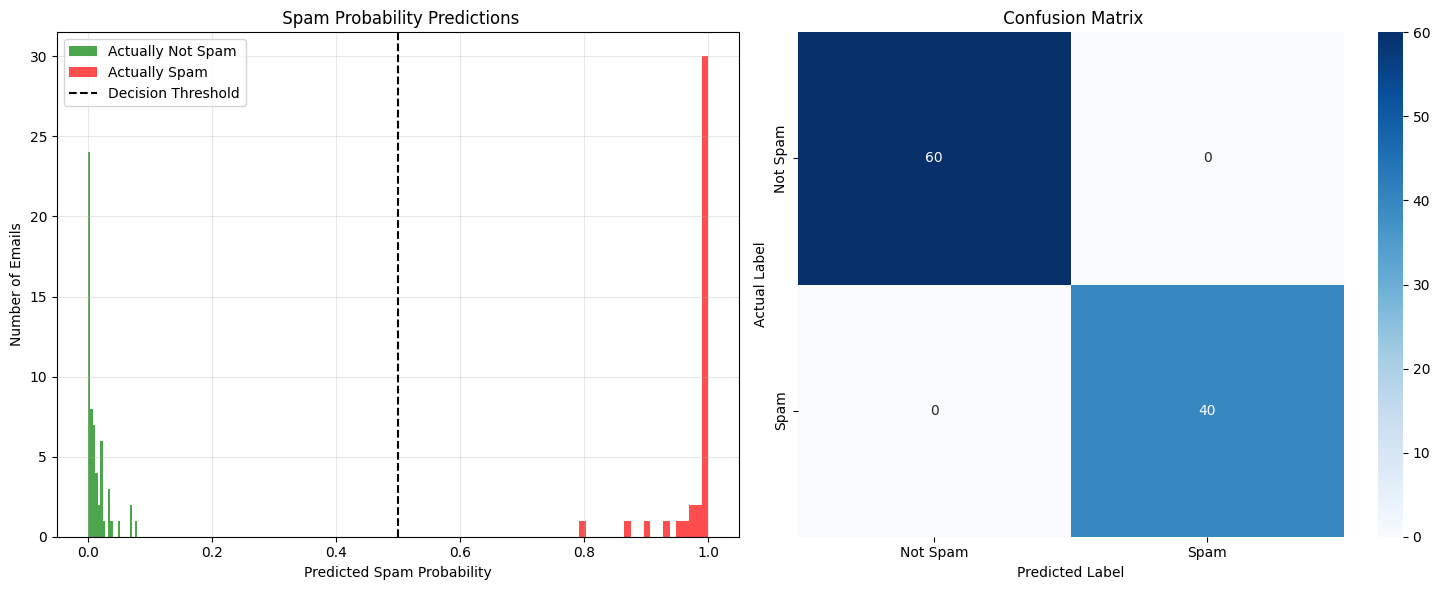

 How to read these plots:
Left: Green bars should be left (low probability), red bars should be right (high probability)
Right: TopLeft to LeftBottom Diagonal shows correct predictions, other diagonal shows errors


In [24]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Probability distribution
ax1.hist(y_pred_proba[y_test_email == 0], bins=20, alpha=0.7, label='Actually Not Spam', color='green')
ax1.hist(y_pred_proba[y_test_email == 1], bins=20, alpha=0.7, label='Actually Spam', color='red')
ax1.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
ax1.set_xlabel('Predicted Spam Probability')
ax1.set_ylabel('Number of Emails')
ax1.set_title(' Spam Probability Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(y_test_email, y_pred_email)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Actual Label')
ax2.set_title(' Confusion Matrix')
ax2.set_xticklabels(['Not Spam', 'Spam'])
ax2.set_yticklabels(['Not Spam', 'Spam'])

plt.tight_layout()
plt.show()

print(" How to read these plots:")
print("Left: Green bars should be left (low probability), red bars should be right (high probability)")
print("Right: TopLeft to LeftBottom Diagonal shows correct predictions, other diagonal shows errors")

---

# Summary

Great job completing the logistic regression section!

##What we learned:

✅ Built spam email classifier model using scikit-learn



✅ Worked with pandas library to create dataset


✅ Visualized our data


✅ Trained and tested our classifier model